# Dimension-wise Class Activation Map (dCAM)



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm_notebook as tqdm

In [3]:
sys.path.insert(0, '../src/models')
sys.path.insert(0, '../src/explanation')

from CNN_models import *
from DCAM import *

## Functions for synthetic dataset construction
### Parameters

In [4]:
# Number of instance of Class 1 to concatenate on each dimension
nb_seq = 5
# Number of dimensions
nb_dim = 8
# Number of instance per class
nb_instance = 200
# train-test ratio
train_test_r = 0.75

### Functions

In [5]:

def generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_set=None,side=0):
    result = []
    rand_side = side
    if pos_anom_set is not None:
        pos_anom = pos_anom_set
    else:
        pos_anom = randint(0,nb_seq-1)
    for i in range(nb_seq):
        if i == pos_anom:
            if rand_side == 1:
                result += list(np.array(all_class_2[randint(0,len(all_class_2)-1)]))
            elif rand_side == 0:
                result += [cl2 for cl2 in all_class_2[randint(0,len(all_class_2)-1)]]
        else:
            result += all_class_1[randint(0,len(all_class_1)-1)]
    if side == 0:
        return [res for i,res in enumerate(result) if i % 15 == 0]
    else:
        return [res for i,res in enumerate(result) if i % 15 == 0]
        
def generate_normal(nb_seq,all_class_1,side=0):
    result = []
    for i in range(nb_seq):
        result += all_class_1[randint(0,len(all_class_1)-1)]
    if side == 0:
        return [res for i,res in enumerate(result) if i % 15 == 0]
    else:
        return [res for i,res in enumerate(result) if i % 15 == 0]
        
def generate_multivaraite_norm(nb_dim,nb_seq,all_class_1):
    instance = []
    for i in range(nb_dim):
        instance.append(generate_normal(nb_seq,all_class_1,side = i%2))
    return instance,[]

def generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2,nb_k=2):
    instance = []
    all_rand_pos = []
    for i in range(nb_k):
        rand_pos = randint(0,nb_dim-1)
        while (rand_pos in all_rand_pos):
            rand_pos = randint(0,nb_dim-1)
        all_rand_pos.append(rand_pos)
    groundtruth = []
    all_pos_anom = []
    for i in range(nb_k):
        pos_anom = randint(0,nb_seq-1)
        while pos_anom in all_pos_anom: 
            pos_anom = randint(0,nb_seq-1)
        all_pos_anom.append(pos_anom)
    for i in range(nb_dim):
        found = False
        for rand_pos_2,pos_anom_2 in zip(all_rand_pos,all_pos_anom):
            if rand_pos_2 == i:
                instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side = i%2))#randint(0,1)))
                anom_length = len(all_class_1[0])//15 + 1
                groundtruth.append([0]*(anom_length*pos_anom_2) + [1]*anom_length + [0]*((nb_seq - pos_anom_2-1)*anom_length))
                found = True
                break
        if not found:
            instance.append(generate_normal(nb_seq,all_class_1,side = i%2))#randint(0,1)))
            groundtruth.append([0]*len(instance[-1]))
    return instance,groundtruth

def generate_multivaraite_abnormal_same(nb_dim,nb_seq,all_class_1,all_class_2):
    instance = []
    rand_pos = 1#randint(0,nb_dim-1)
    rand_pos_2 = 8#randint(0,nb_dim-1)
    while (rand_pos_2 == rand_pos):
        rand_pos_2 = randint(0,nb_dim-1)
    pos_anom_1 = randint(0,nb_seq-1)
    pos_anom_2 = randint(0,nb_seq-1)
    while pos_anom_2 ==  pos_anom_1: 
        pos_anom_2 = randint(0,nb_seq-1)
    for i in range(nb_dim):
        if i == rand_pos:
            instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_1,side=0))
        elif rand_pos_2 == i:
            instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side=1))
        else:
            instance.append(generate_normal(nb_seq,all_class_1))
    return instance


def generate_multivaraite_abnormal_sync(nb_dim,nb_seq,all_class_1,all_class_2,nb_k=2):
    instance = []
    all_rand_pos = []
    for i in range(nb_k):
        rand_pos = randint(0,nb_dim-1)
        while (rand_pos in all_rand_pos):
            rand_pos = randint(0,nb_dim-1)
        all_rand_pos.append(rand_pos)
    groundtruth = []
    pos_anom_2 = randint(0,nb_seq-1)
    for i in range(nb_dim):
        found = False
        for rand_pos_2 in all_rand_pos:
            if rand_pos_2 == i:
                instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side = i%2))#randint(0,1)))
                anom_length = len(all_class_1[0])//15 + 1
                groundtruth.append([0]*(anom_length*pos_anom_2) + [1]*anom_length + [0]*((nb_seq - pos_anom_2-1)*anom_length))
                found = True
                break
        if not found:
            instance.append(generate_normal(nb_seq,all_class_1,side = i%2))#randint(0,1)))
            groundtruth.append([0]*len(instance[-1]))
    return instance,groundtruth

def gen_cube(instance):
    result = []
    for i in range(len(instance)):
        result.append([instance[(i+j)%len(instance)] for j in range(len(instance))])
    return result

def gen_line(instance):
    result = []
    for i in range(len(instance)):
        result.append([instance[i]])
    return result

### Reading the dataset

In [6]:
df = pd.read_csv("../data/examples/data.tsv",sep='\t',header=None)

all_class_1 = []
all_class_2 = []
for index in range(len(df)):
    to_add = (df.values[index][1:] - np.mean(df.values[index][1:]))/(np.std(df.values[index][1:]))
    if df.values[index][0] == 3.0: 
        all_class_1.append(list(to_add))
    elif df.values[index][0] == 2.0: 
        all_class_2.append(list(to_add))
        

### Building our Synthetic Dataset

In [7]:
#Anomaly Type 1

Class1 = [generate_multivaraite_norm(nb_dim,nb_seq,all_class_1)[0] for j in range(nb_instance)]
Class2 = [generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]

#Anomaly Type 2

#Class1 = [generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]
#Class2 = [generate_multivaraite_abnormal_sync(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]

### Class 2 instance Visualization 

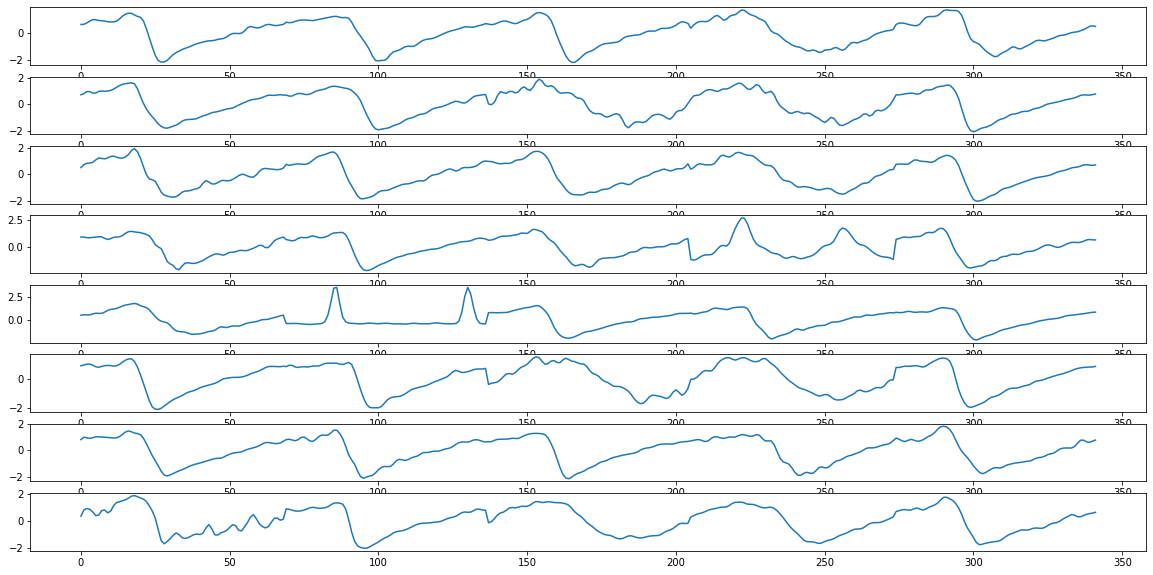

In [8]:
plt.figure(figsize=(20,10))
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class2[7][i])

### Training Parameter

In [9]:
# training parameter
device='cpu'
original_length = len(Class1[0][0])
num_classes = 2
batch_size = 32
original_dim = nb_dim

### Generate pyTorch-like datasets 

In [10]:
label = [1]*100 + [0]*100
label_test = [1]*24 + [0]*24

label = np.array(label)
label_test = np.array(label_test)

all_class = Class1[:100] + Class2[:100]
all_class_test = Class1[100:124] + Class2[100:124]


all_class = np.array([gen_cube(acl) for acl in all_class])
all_class_test = np.array([gen_cube(acl) for acl in all_class_test])

x = all_class
dataset_mat = TSDataset(x,label)
dataloader_cl1 = data.DataLoader(dataset_mat, batch_size=batch_size, shuffle=True)

x = all_class_test
dataset_mat_test = TSDataset(x,label_test)
dataloader_cl1_test = data.DataLoader(dataset_mat_test, batch_size=1, shuffle=True)

In [11]:
print(np.shape(all_class))
print(np.shape(all_class_test))

(200, 8, 8, 342)
(48, 8, 8, 342)


# Training the model

Note that the usage of Batchnorm layer is not appropriate to all use cases. By expirience, this layer cause an instablility and a lower convergence is some of the use cases tested. It seems that this layer make some pertubation fail to be classified.

### Training the model

In [12]:
from torchsummary import summary

#dCNN
modelarch = ConvNet2D(original_length,original_dim,original_dim,num_classes).to(device)
#dResNet
#modelarch = dResNetBaseline(original_dim,mid_channels=128,num_pred_classes=num_classes).to(device)
#dInceptiontime
#modelarch = dInceptionModel(num_blocks=3, in_channels=original_dim, out_channels=64,
#                            bottleneck_channels=64, kernel_sizes=[10,20,40],
#                            use_residuals=True, num_pred_classes=num_classes).to(device)


model = ModelCNN(modelarch,device)

summary(model.model.to(device),input_size=(original_dim,original_dim,original_length))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 8, 342]           3,200
       BatchNorm2d-2          [-1, 128, 8, 342]             256
              ReLU-3          [-1, 128, 8, 342]               0
            Conv2d-4          [-1, 128, 8, 342]          49,280
       BatchNorm2d-5          [-1, 128, 8, 342]             256
              ReLU-6          [-1, 128, 8, 342]               0
            Conv2d-7          [-1, 256, 8, 342]          98,560
       BatchNorm2d-8          [-1, 256, 8, 342]             512
              ReLU-9          [-1, 256, 8, 342]               0
           Conv2d-10          [-1, 256, 8, 342]         196,864
      BatchNorm2d-11          [-1, 256, 8, 342]             512
             ReLU-12          [-1, 256, 8, 342]               0
           Conv2d-13          [-1, 256, 8, 342]         196,864
             ReLU-14          [-1, 256,

In [13]:
model.train(num_epochs=70,dataloader_cl1=dataloader_cl1,dataloader_cl1_test=dataloader_cl1_test)

Epoch [1/70], Loss Train: 0.7006,Loss Test: 0.6934, Accuracy Train: 50.00%, Accuracy Test: 50.00%
Epoch [11/70], Loss Train: 0.6547,Loss Test: 0.6552, Accuracy Train: 85.00%, Accuracy Test: 85.42%
Epoch [21/70], Loss Train: 0.5961,Loss Test: 0.5963, Accuracy Train: 92.00%, Accuracy Test: 91.67%
Epoch [31/70], Loss Train: 0.5185,Loss Test: 0.5020, Accuracy Train: 96.00%, Accuracy Test: 97.92%
Epoch [41/70], Loss Train: 0.4116,Loss Test: 0.3889, Accuracy Train: 97.50%, Accuracy Test: 97.92%
Epoch [51/70], Loss Train: 0.3284,Loss Test: 0.2909, Accuracy Train: 99.50%, Accuracy Test: 100.00%
Epoch [61/70], Loss Train: 0.2490,Loss Test: 0.2246, Accuracy Train: 99.50%, Accuracy Test: 100.00%


### Train and test loss (Binary Cross Entropy) versus Epoch  

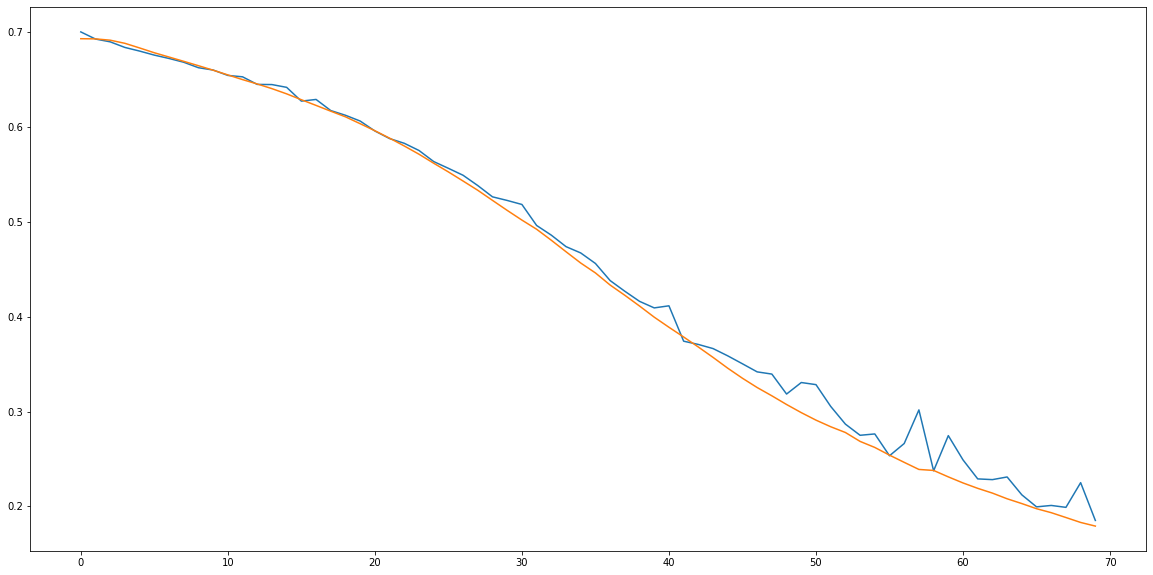

In [14]:
plt.figure(figsize=(20,10))
plt.plot(model.loss_train_history)
plt.plot(model.loss_test_history)

# d-CAM Class Activation Map


In [15]:
model = torch.load("model").to(device)
model = model.eval()

instance = np.array(Class2[3])
label_instance = 0

instance_to_try = Variable(
    torch.tensor(
        instance.reshape(
            (1,1,original_dim,original_length))).float().to(device),
    requires_grad=True)


# dCNN
last_conv_layer = model._modules['layer3']
fc_layer_name = model._modules['fc1']

# dResNet
#last_conv_layer = model.model._modules['layers'][2]
#fc_layer_name = model.model._modules['final']

#InceptionTime
#last_conv_layer = model.model._modules['blocks'][2]
#fc_layer_name = model.model._modules['linear']



DCAM_m = DCAM(model,device,last_conv_layer=last_conv_layer,fc_layer_name=fc_layer_name)
dcam,permutation_success = DCAM_m.run(
    instance=instance,
    nb_permutation=200,
    label_instance=label_instance)

  0%|          | 0/200 [00:00<?, ?it/s]../src/explanation/DCAM.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()
100%|██████████| 200/200 [00:07<00:00, 25.22it/s]


dcam


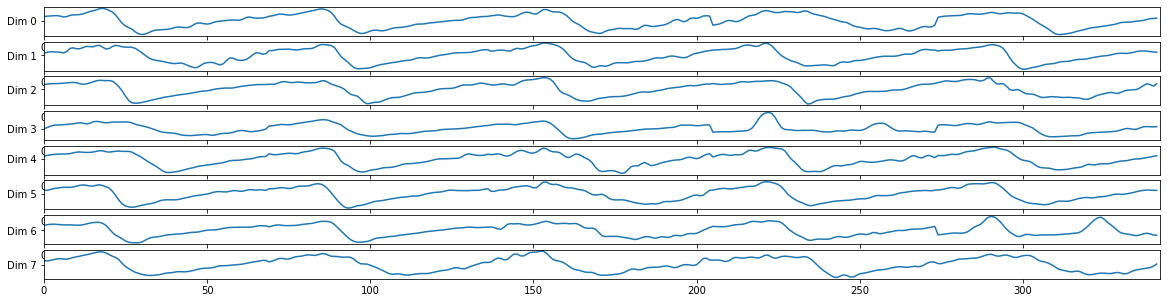

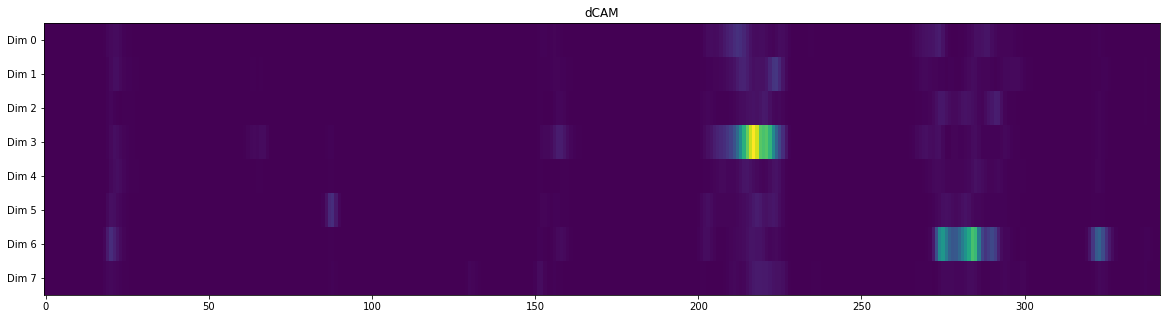

In [16]:
plt.figure(figsize=(20,5))
plt.title('multivariate data series')
for i in range(len(instance)):
    plt.subplot(len(instance),1,1+i)
    plt.plot(instance[i])
    plt.xlim(0,len(instance[i]))
    plt.yticks([0],["Dim {}".format(i)])

plt.figure(figsize=(20,5))
plt.title('dCAM')
plt.imshow(dcam,aspect='auto',interpolation=None)
plt.yticks(list(range(nb_dim)), ["Dim {}".format(i) for i in range(nb_dim)])
print('dcam')
#plt.colorbar(img)